## Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade langgraph transformers peft accelerate bitsandbytes "scikit-learn==1.6.1" joblib "pandas==2.2.2" langchain-core langchain

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import os
import sqlite3
import torch
from typing import TypedDict, Optional, Dict, Literal
from pydantic import BaseModel, field_validator
from math import exp
from datetime import datetime

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# DEFINE PATHS

BASE_PATH           = "/content/drive/MyDrive/Work/Capstone_Organized" # CHANGE THIS WHEN YOU USE THE NOTEBOOK, ENSURE THE FINAL DESTINATION IS Capstone_Organized
ML_ARTIFACT_PATH    = BASE_PATH + "/3-Model_Training/3.1-Traditional_ML/3.1.0-Traditional_ML_Artifacts"
LLM_ARTIFACT_PATH   = BASE_PATH + "/3-Model_Training/3.2-LLM_Classification/3.2.0-FineTune_OpenBioLLM"

DB_PATH             = os.path.join(BASE_PATH + "/1-Data/ED_Simulated_Database_Fixed.db")

ML_MODEL_PATH       = os.path.join(ML_ARTIFACT_PATH, "gb_model.joblib")
ML_PREPROCESSOR_PATH= os.path.join(ML_ARTIFACT_PATH, "ml_preprocessor.joblib")
ML_FEATURES_PATH    = os.path.join(ML_ARTIFACT_PATH, "ml_feature_columns.json")

LLM_MODEL_ID        = "aaditya/Llama3-OpenBioLLM-8B"
LLM_MODEL_PATH      = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Final")
LLM_OFFLOAD_PATH    = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Offload")
os.makedirs(LLM_OFFLOAD_PATH, exist_ok=True)

assert os.path.exists(ML_MODEL_PATH), f"ML Model not found: {ML_MODEL_PATH}"
assert os.path.exists(ML_PREPROCESSOR_PATH), f"ML Preprocessor not found: {ML_PREPROCESSOR_PATH}"
assert os.path.exists(ML_FEATURES_PATH), f"ML Features JSON not found: {ML_FEATURES_PATH}"
assert os.path.exists(LLM_MODEL_PATH), f"LLM Checkpoint not found: {LLM_MODEL_PATH}"
assert os.path.exists(DB_PATH), f"Simulation DB not found: {DB_PATH}"

print("All model artifacts and simulation DB paths are verified.")

All model artifacts and simulation DB paths are verified.


## Load Artifacts & Define Helper Functions

In [ ]:
# LOAD ML ARTIFACTS

# Define function for joblib pointer
def clean_text_for_ml(text: str) -> str:
    """
    Cleans the *already redacted* notes for TF-IDF.
    This version removes the [AGE] tags and all non-alpha characters.
    (Copied from 3.1.1-Traditional_ML_Training.ipynb)
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\\[.*?\\]', ' ', text) # Remove tags like [AGE]
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove special characters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Consolidate whitespace
    return text

# Load joblib files
ml_model = joblib.load(ML_MODEL_PATH)
ml_preprocessor = joblib.load(ML_PREPROCESSOR_PATH)

with open(ML_FEATURES_PATH, 'r') as f:
    ml_feature_names = json.load(f)

print(f"Successfully loaded ML model and preprocessor ({len(ml_feature_names)} features).")

Successfully loaded ML model and preprocessor (143 features).


In [ ]:
# LOAD LLM ARTIFACTS

tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForSequenceClassification.from_pretrained(
    LLM_MODEL_ID,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # Requires a GPU!
    offload_folder=LLM_OFFLOAD_PATH
)
if base_model.config.pad_token_id is None:
    base_model.config.pad_token_id = tokenizer.pad_token_id

llm_model = PeftModel.from_pretrained(base_model, LLM_MODEL_PATH)
llm_model.eval()

print("Successfully loaded fine-tuned OpenBioLLM model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully loaded fine-tuned OpenBioLLM model.


In [ ]:
# LOAD HELPER FUNCTIONS

# --- Helper for LLM Prediction ---
def format_for_llm(patient_data: dict) -> str:
    """
    Formats the raw DB row (as a dict) into the single string
    our LLM was trained on. (Uses 'age_bucket')
    """
    return (
        f"age range: {patient_data.get('age_bucket')} / "
        f"sex: {patient_data.get('sex')} / "
        f"heart rate: {patient_data.get('heart_rate')} / "
        f"systolic blood pressure: {patient_data.get('bp_systolic')} / "
        f"diastolic blood pressure: {patient_data.get('bp_diastolic')} / "
        f"respiratory rate: {patient_data.get('resp_rate')} / "
        f"temperature in Celsius: {patient_data.get('temperature_C')} / "
        f"oxygen saturation: {patient_data.get('oxygen_saturation')} / "
        f"ESI: {int(patient_data.get('ESI', 0))} / "
        f"recent admissions (in 30 days): {int(patient_data.get('recent_admissions_30d', 0))} / "
        f"{patient_data.get('triage_notes_redacted', '')}"
    )

def llm_predict_proba(text: str) -> float:
    """
    Runs the formatted text through the LLM and returns the
    probability of 'Admit' (class 1).
    """
    device = llm_model.device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = llm_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
        return float(probs[1].cpu().numpy())


# --- Helper for ML Prediction ---
def ml_predict_proba(patient_data: dict) -> float:
    """
    Runs the raw data through the ML preprocessor and model
    and returns the probability of 'Admit' (class 1).
    """
    # Convert the single patient dict into a 1-row DataFrame
    input_df = pd.DataFrame([patient_data])

    # Transform the DataFrame using our loaded 'ml_preprocessor' artifact
    transformed_data = ml_preprocessor.transform(input_df)

    # Create the final DataFrame with the correct feature names
    input_transformed_df = pd.DataFrame(
            transformed_data.toarray(),  # <--- ADDED .toarray()
            columns=ml_feature_names
    )
    # Predict probability
    prob_admit = ml_model.predict_proba(input_transformed_df)[0][1]
    return float(prob_admit)

print("Model helper functions defined.")

Model helper functions defined.


### Define Graph State

In [ ]:
class VitalSigns(BaseModel):
    """Pydantic model for validating vital signs."""
    sex: Optional[str] = None
    age_bucket: Optional[str] = None
    heart_rate: Optional[float] = None
    resp_rate: Optional[float] = None
    bp_systolic: Optional[float] = None
    bp_diastolic: Optional[float] = None
    oxygen_saturation: Optional[float] = None
    temperature_C: Optional[float] = None
    ESI: Optional[int] = None
    mental_status: Optional[str] = None
    recent_admissions_30d: Optional[int] = None


class ERState(TypedDict):
    """Defines the state of our graph."""
    visit_id: int
    human_prompt: str
    patient_data: Dict
    vitals_validated: VitalSigns
    triage_text: str
    ml_score: float
    llm_score: float
    severe: bool
    p_final: float
    decision: str
    confidence: float
    rationale: str

print("LangGraph state defined.")

LangGraph state defined.


In [ ]:
# --- Node 1: Fetch Data from DB ---
def fetch_data_node(state: ERState):
    """
    Takes a visit_id, connects to the DB, and fetches the patient's
    de-identified data from Visit_Details, Triage_Notes, and ESI.
    """
    print(f"--- 1. Fetching data for visit_id: {state['visit_id']} ---")

    conn = None
    try:
        conn = sqlite3.connect(DB_PATH)
        conn.row_factory = sqlite3.Row # Allows columns access by name

        query = """
        SELECT
            v.visit_id, v.patient_id, v.sex, v.age_bucket,
            v.heart_rate, v.bp_systolic, v.bp_diastolic, v.resp_rate,
            v.temperature_C, v.oxygen_saturation, v.recent_admissions_30d,
            v.admitted,
            t.triage_notes_redacted,
            e.ESI
        FROM Visit_Details v
        LEFT JOIN Triage_Notes t ON v.visit_id = t.visit_id AND v.patient_id = t.patient_id
        LEFT JOIN ESI e ON v.visit_id = e.visit_id AND v.patient_id = e.patient_id
        WHERE v.visit_id = ?
        """

        cursor = conn.cursor()
        cursor.execute(query, (state['visit_id'],))
        row = cursor.fetchone()

    except Exception as e:
        print(f"DB Error: {e}")
        raise
    finally:
        if conn:
            conn.close()

    if row is None:
        raise ValueError(f"No data found for visit_id: {state['visit_id']} in {DB_PATH}")

    patient_data = dict(row)

    return {
        "patient_data": patient_data,
        "vitals_validated": VitalSigns(**patient_data),
        "triage_text": patient_data.get('triage_notes_redacted', '')
    }

# --- Node 2: Severity Gate ---
def severity_gate_node(state: ERState):
    """
    Checks for any critical vital signs. (Unchanged)
    """
    print("--- 2. Checking severity gate ---")
    v = state["vitals_validated"]

    if (v.oxygen_saturation is not None and v.oxygen_saturation < 88) or \
       (v.bp_systolic is not None and v.bp_systolic < 80) or \
       (v.resp_rate is not None and (v.resp_rate > 35 or v.resp_rate < 8)):
        print(" -> CRITICAL: Patient is severe. Bypassing models.")
        return {
            "severe": True,
            "decision": "Admit",
            "p_final": 1.0,
            "rationale": "Critical vital signs detected. Bypassed ML/LLM."
        }

    print(" -> OK: Patient is not severe. Proceeding to models.")
    return {"severe": False}

In [ ]:
# --- Node 3a: ML Model ---
def ml_model_node(state: ERState):
    """
    Runs the patient data through the retrained ML pipeline.
    """
    print("--- 3a. Running ML Model ---")
    score = ml_predict_proba(state['patient_data'])
    print(f" -> ML Score (P_Admit): {score:.4f}")
    return {"ml_score": score}

# --- Node 3b: LLM Model ---
def llm_model_node(state: ERState):
    """
    Runs the patient data through the retrained LLM pipeline.
    """
    print("--- 3b. Running LLM Model ---")
    formatted_text = format_for_llm(state['patient_data'])
    score = llm_predict_proba(formatted_text)
    print(f" -> LLM Score (P_Admit): {score:.4f}")
    return {"llm_score": score}

# --- Node 3c: Human Input ---
def human_input_node(state: ERState):
    """
    This node simply acknowledges the human prompt.
    """
    print("--- 3c. Acknowledging Human Input ---")
    print(f" -> Human Note: '{state['human_prompt']}'")
    return {}

In [ ]:
# --- Node 4: Fusion ---
def fusion_node(state: ERState):
    """
    Fuses the scores from the ML model, LLM, and human prompt
    to make a final decision.
    """
    print("--- 4. Fusing Model & Human Inputs ---")

    p_ml = state.get("ml_score", 0.5)
    p_llm = state.get("llm_score", 0.5)
    human_note = (state.get("human_prompt") or "").lower()

    # 1. Base score: Weighted average
    p_weighted = (0.5 * p_ml) + (0.5 * p_llm)
    rationale = f"Weighted Fusion: 50% ML ({p_ml:.2f}) + 50% LLM ({p_llm:.2f}) = {p_weighted:.2f}."

    # 2. Apply "overrides" from human note
    if "frail" in human_note or "chemo" in human_note or "high risk" in human_note:
        p_final = p_weighted * 1.25
        rationale += f" Human note '{human_note}' indicates high risk. Boosting score."
    elif "no distress" in human_note or "stable" in human_note or "follow-up" in human_note:
        p_final = p_weighted * 0.75
        rationale += f" Human note '{human_note}' indicates low risk. Reducing score."
    else:
        p_final = p_weighted
        rationale += " No strong human override."

    p_final = max(0, min(1.0, p_final))

    # 3. Make Final Decision
    ADMISSION_THRESHOLD = 0.4 # Our "optimal" threshold
    decision = "Admit" if p_final >= ADMISSION_THRESHOLD else "Discharge"
    confidence = abs(p_final - ADMISSION_THRESHOLD)

    print(f" -> Final P(Admit): {p_final:.4f} | Decision: {decision}")

    return {
        "p_final": p_final,
        "decision": decision,
        "confidence": confidence,
        "rationale": rationale
    }

# --- Conditional Edge: Severity Gate ---
def conditional_severity_gate(state: ERState):
    """
    Checks the 'severe' flag to route the graph.
    """
    if state.get("severe", False):
        return "end" # Go straight to the end
    else:
        return "run_models" # Proceed to parallel branches

## Initiate the Graph

In [ ]:
# 1. Initialize the graph
workflow = StateGraph(ERState)

# 2. *** NEW: Define a "dummy" node for parallel execution ***
# This node does nothing but act as a branching point.
def run_models_node(state: ERState):
    """
    This is a router node that triggers the parallel model runs.
    """
    print("--- 3. Fanning out to parallel models ---")
    return {}

# 3. Add all the nodes
workflow.add_node("fetch_data", fetch_data_node)
workflow.add_node("severity_gate", severity_gate_node)
workflow.add_node("run_models", run_models_node) # <-- ADD THE DUMMY NODE
workflow.add_node("ml_model", ml_model_node)
workflow.add_node("llm_model", llm_model_node)
workflow.add_node("human_input", human_input_node)
workflow.add_node("fusion", fusion_node)

# 4. Define the graph flow
workflow.set_entry_point("fetch_data")
workflow.add_edge("fetch_data", "severity_gate")

# 5. Add conditional branch
# This now correctly routes to the *string name* of our dummy node
workflow.add_conditional_edges(
    "severity_gate",
    conditional_severity_gate,
    {
        "run_models": "run_models",
        "end": END
    }
)

# 6. Define Parallel Fan-Out
# Add three separate edges *from* the dummy node
workflow.add_edge("run_models", "ml_model")
workflow.add_edge("run_models", "llm_model")
workflow.add_edge("run_models", "human_input")

# 7. Define convergence
workflow.add_edge("ml_model", "fusion")
workflow.add_edge("llm_model", "fusion")
workflow.add_edge("human_input", "fusion")

# 8. Define end
workflow.add_edge("fusion", END)

# 9. Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

print("\n--- LangGraph Compiled Successfully! ---")


--- LangGraph Compiled Successfully! ---


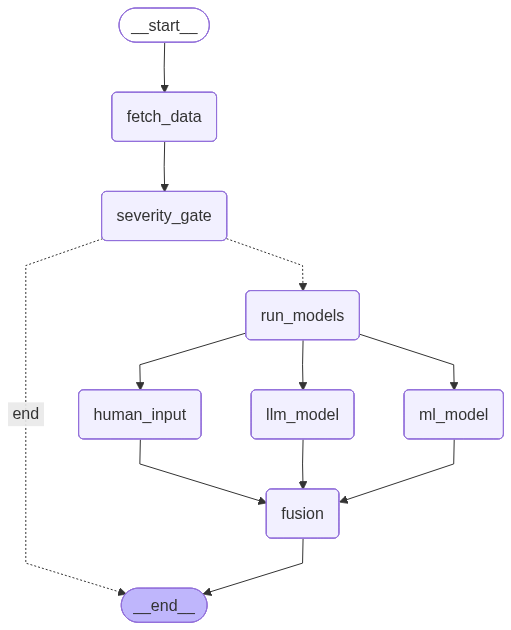

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Could not draw graph. Skipping visualization.")

## Test Run the Graph

In [ ]:
# --- Run 1: High-Risk Patient Note ---
# We'll use visit_id=1 and add a high-risk note
inputs_1 = {
    "visit_id": 1,
    "human_prompt": "Patient is 70yo, frail, and on chemotherapy."
}
config = {"configurable": {"thread_id": "sim-1"}}

print("--- Running Simulation 1 (High-Risk Note) ---")
final_state_1 = graph.invoke(inputs_1, config)

print("\n--- Final State 1 ---")
print(f"Decision: {final_state_1['decision']}")
print(f"P(Admit): {final_state_1['p_final']:.4f}")
print(f"Rationale: {final_state_1['rationale']}")


# --- Run 2: Low-Risk Patient Note ---
# We'll use visit_id=5 (assuming this is a lower-risk patient in the DB)
inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}
config = {"configurable": {"thread_id": "sim-2"}}

print("\n\n--- Running Simulation 2 (Low-Risk Note) ---")
final_state_2 = graph.invoke(inputs_2, config)

print("\n--- Final State 2 ---")
print(f"Decision: {final_state_2['decision']}")
print(f"P(Admit): {final_state_2['p_final']:.4f}")
print(f"Rationale: {final_state_2['rationale']}")

--- Running Simulation 1 (High-Risk Note) ---
--- 1. Fetching data for visit_id: 1 ---
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
--- 3. Fanning out to parallel models ---
--- 3c. Acknowledging Human Input ---
 -> Human Note: 'Patient is 70yo, frail, and on chemotherapy.'
--- 3b. Running LLM Model ---
--- 3a. Running ML Model ---
 -> ML Score (P_Admit): 0.8125
 -> LLM Score (P_Admit): 0.9899
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 1.0000 | Decision: Admit

--- Final State 1 ---
Decision: Admit
P(Admit): 1.0000
Rationale: Weighted Fusion: 50% ML (0.81) + 50% LLM (0.99) = 0.90. Human note 'patient is 70yo, frail, and on chemotherapy.' indicates high risk. Boosting score.


--- Running Simulation 2 (Low-Risk Note) ---
--- 1. Fetching data for visit_id: 5 ---
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
--- 3. Fanning out to parallel models ---
--- 3c. Acknowledging Human Input ---
 -> 

## Evaluate the Graph

To maintain consistency, we will be using the 4200-row csv dataset that was used to train/test the LLM Classifier and the ML Model. The purpose of the graph workflow above using a database is to simulate a real-world workflow. For evaluation, we will be using a csv format.

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
INPUT_CSV_PATH = os.path.join(BASE_PATH + "/1-Data/ED_Model_Training_Dataset.csv")

df_full = pd.read_csv(INPUT_CSV_PATH)
df_full = df_full.dropna().reset_index(drop=True)
print(f"Loaded {len(df_full)} rows from {INPUT_CSV_PATH}.")

Loaded 4200 rows from /content/drive/MyDrive/Work/Capstone_Organized/1-Data/ED_Model_Training_Dataset.csv.


In [ ]:
# PII MASKING: age

def bucket_age(a):
    """Bins the age column into categorical ranges."""
    if pd.isna(a): return None
    a = int(a)
    if a <= 17: return "0-17"
    if a <= 34: return "18-34"
    if a <= 49: return "35-49"
    if a <= 64: return "50-64"
    return "65+"

df_full["age_bucket"] = df_full["age"].apply(bucket_age)

In [ ]:
# PII MASKING: triage_notes

EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE  = re.compile(r"\b(?:\+?1[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}\b")
SSN_RE    = re.compile(r"\b\d{3}-?\d{2}-?\d{4}\b")
DATE_RE   = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b")

# Normalize unicode dashes to ASCII hyphen
DASHES = dict.fromkeys(map(ord, "\u2010\u2011\u2012\u2013\u2014\u2015"), "-")

AGE_PATTERNS = [
    re.compile(r"\b(\d{1,3})\W*(?:year|yrs?|yo|y\/?o)\W*(?:old|of\s+age)?\b", re.IGNORECASE), # Catch X-year-old, X y/o, X yrs, etc.
    re.compile(r"\bage[d]?\s*(\d{1,3})\b", re.IGNORECASE), # Catch aged X / age X
    re.compile(r"\b(in\s+(?:his|her|their|a|the)\s+)\d{2}s\b", re.IGNORECASE) # Catching decades (in his 40s)
]

# Gendered words/titles and pronouns
GENDER_RE   = re.compile(r"\b(male|female|man|woman|boy|girl|gentleman|lady|mr\.?|mrs\.?|ms\.?)\b", re.IGNORECASE)
PRONOUN_RE  = re.compile(r"\b(he|she|him|her|his|hers)\b", re.IGNORECASE)
_PRONOUN_MAP = {'he':'they','she':'they','him':'them','her':'them','his':'their','hers':'their'}

def _neutralize_pronouns(text: str) -> str:
    def _sub(m):
        src = m.group(1)
        repl = _PRONOUN_MAP[src.lower()]
        if src.isupper():     return repl.upper()
        if src[0].isupper():  return repl.capitalize()
        return repl
    return PRONOUN_RE.sub(_sub, text)

def _remove_age(m):
    """Removes the entire matched age phrase."""
    return ""

def redact_text(s):
    """Redact PII + demographics; REMOVES all numeric ages."""
    if pd.isna(s):
        return None
    t = str(s).translate(DASHES)

    # PII
    t = EMAIL_RE.sub("[EMAIL]", t)
    t = PHONE_RE.sub("[PHONE]", t)
    t = SSN_RE.sub("[SSN]", t)
    t = DATE_RE.sub("[DATE]", t)

    # Ages → REMOVE (using the aggressive patterns above)
    for rx in AGE_PATTERNS:
        # This replaces the entire matched phrase (e.g., "67-year-old") with "[AGE]"
        t = rx.sub(_remove_age, t)

    # Gendered terms and pronouns
    t = GENDER_RE.sub("the patient", t)
    t = _neutralize_pronouns(t)

    return re.sub(r"\s+", " ", t).strip()

df_full["triage_notes_redacted"] = df_full["triage_notes"].apply(redact_text)
test_note_redacted = df_full["triage_notes_redacted"].iloc[0]
print("\nOriginal Note:")
print(test_note_redacted)


Original Note:
the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    4200 non-null   int64  
 1   sex                    4200 non-null   object 
 2   triage_notes           4200 non-null   object 
 3   heart_rate             4200 non-null   int64  
 4   bp_systolic            4200 non-null   int64  
 5   bp_diastolic           4200 non-null   int64  
 6   resp_rate              4200 non-null   int64  
 7   temperature_C          4200 non-null   float64
 8   oxygen_saturation      4200 non-null   float64
 9   ESI                    4200 non-null   int64  
 10  recent_admissions_30d  4200 non-null   int64  
 11  admitted               4200 non-null   int64  
 12  age_bucket             4200 non-null   object 
 13  triage_notes_redacted  4200 non-null   object 
dtypes: float64(2), int64(8), object(4)
memory usage: 459.5+ 

In [ ]:
df_full = df_full.drop(columns=['triage_notes', 'age'])

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    4200 non-null   object 
 1   heart_rate             4200 non-null   int64  
 2   bp_systolic            4200 non-null   int64  
 3   bp_diastolic           4200 non-null   int64  
 4   resp_rate              4200 non-null   int64  
 5   temperature_C          4200 non-null   float64
 6   oxygen_saturation      4200 non-null   float64
 7   ESI                    4200 non-null   int64  
 8   recent_admissions_30d  4200 non-null   int64  
 9   admitted               4200 non-null   int64  
 10  age_bucket             4200 non-null   object 
 11  triage_notes_redacted  4200 non-null   object 
dtypes: float64(2), int64(7), object(3)
memory usage: 393.9+ KB


In [ ]:
TARGET_COLUMN = 'admitted'
y = df_full[TARGET_COLUMN]
X = df_full.drop(columns=[TARGET_COLUMN])

In [ ]:
_, X_test, _, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=14,
    stratify=y
)

test_patients = X_test.to_dict('records')
true_labels = y_test.tolist()

print(f"Created evaluation set with {len(test_patients)} patients.")

Created evaluation set with 840 patients.


In [ ]:
print(f"Running Head-to-Head evaluation on {len(test_patients)} test patients...")

results = []
neutral_human_prompt = "No human note provided."

# Use tqdm for a progress bar
for i, patient_data in enumerate(tqdm(test_patients)):

    try:
        # We now have the raw patient_data dict from our CSV test set

        # --- 1. Check Severity Gate ---
        # We must run this just as the agent would
        vitals = VitalSigns(**patient_data) # Validate the data
        is_severe = (
            (vitals.oxygen_saturation is not None and vitals.oxygen_saturation < 88) or
            (vitals.bp_systolic is not None and vitals.bp_systolic < 80) or
            (vitals.resp_rate is not None and (vitals.resp_rate > 35 or vitals.resp_rate < 8))
        )

        ml_prob = 0.5
        llm_prob = 0.5
        agent_prob = 0.5
        agent_decision = 0
        agent_rationale = "N/A"

        if is_severe:
            # If the gate catches it, all systems "Admit"
            ml_prob = 1.0
            llm_prob = 1.0
            agent_prob = 1.0
            agent_decision = 1 # 1 for Admit
            agent_rationale = "Critical vital signs detected. Bypassed ML/LLM."
        else:
            # --- 2. Run Individual Models ---
            # Run ML Model (using the helper that renames age_bucket -> age_band)
            ml_prob = ml_predict_proba(patient_data)

            # Run LLM Model (using the helper that formats the string)
            llm_text = format_for_llm(patient_data)
            llm_prob = llm_predict_proba(llm_text)

            # --- 3. Run Fusion Agent Logic ---
            # We manually call the fusion_node function
            fusion_input_state = {
                "ml_score": ml_prob,
                "llm_score": llm_prob,
                "human_prompt": neutral_human_prompt
            }
            agent_state = fusion_node(fusion_input_state)
            agent_prob = agent_state['p_final']
            agent_decision = 1 if agent_state['decision'] == 'Admit' else 0
            agent_rationale = agent_state['rationale']

        # --- 4. Store all results ---
        results.append({
            'true_label': true_labels[i], # Get the matching true label
            'ml_prob': ml_prob,
            'llm_prob': llm_prob,
            'agent_prob': agent_prob,
            'ml_decision': 1 if ml_prob >= 0.4 else 0,
            'llm_decision': 1 if llm_prob >= 0.4 else 0,
            'agent_decision': agent_decision,
            'rationale': agent_rationale
        })

    except Exception as e:
        print(f"Error processing patient {i}: {e}")
        # Log error and continue
        results.append({
            'true_label': true_labels[i],
            'ml_prob': 0.5, 'llm_prob': 0.5, 'agent_prob': 0.5,
            'ml_decision': 0, 'llm_decision': 0, 'agent_decision': 0,
            'rationale': f"ERROR: {e}"
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results).dropna()

print("Agent evaluation complete.")
display(results_df.head())

Running Head-to-Head evaluation on 840 test patients...


  0%|          | 1/840 [00:00<02:19,  6.01it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3910 | Decision: Discharge


  0%|          | 2/840 [00:00<02:10,  6.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3048 | Decision: Discharge


  0%|          | 3/840 [00:00<01:59,  7.00it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1530 | Decision: Discharge


  0%|          | 4/840 [00:00<01:54,  7.31it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0612 | Decision: Discharge


  1%|          | 5/840 [00:00<01:51,  7.46it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4876 | Decision: Admit


  1%|          | 6/840 [00:00<01:55,  7.20it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2550 | Decision: Discharge


  1%|          | 7/840 [00:00<01:58,  7.03it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4600 | Decision: Admit


  1%|          | 8/840 [00:01<02:00,  6.93it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3216 | Decision: Discharge


  1%|          | 9/840 [00:01<02:01,  6.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3010 | Decision: Discharge


  1%|          | 10/840 [00:01<01:56,  7.14it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5850 | Decision: Admit


  1%|▏         | 11/840 [00:01<01:52,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1381 | Decision: Discharge


  1%|▏         | 12/840 [00:01<01:55,  7.15it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5397 | Decision: Admit


  2%|▏         | 13/840 [00:01<01:52,  7.34it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3532 | Decision: Discharge


  2%|▏         | 14/840 [00:01<01:50,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1688 | Decision: Discharge


  2%|▏         | 15/840 [00:02<01:48,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0941 | Decision: Discharge


  2%|▏         | 16/840 [00:02<01:52,  7.33it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4471 | Decision: Admit


  2%|▏         | 17/840 [00:02<01:50,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2028 | Decision: Discharge


  2%|▏         | 18/840 [00:02<01:48,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3650 | Decision: Discharge


  2%|▏         | 19/840 [00:02<01:47,  7.65it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3535 | Decision: Discharge


  2%|▏         | 20/840 [00:02<01:46,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0698 | Decision: Discharge


  2%|▎         | 21/840 [00:02<01:45,  7.75it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2866 | Decision: Discharge


  3%|▎         | 22/840 [00:02<01:44,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1569 | Decision: Discharge


  3%|▎         | 23/840 [00:03<01:49,  7.43it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3359 | Decision: Discharge


  3%|▎         | 24/840 [00:03<01:53,  7.21it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3759 | Decision: Discharge


  3%|▎         | 25/840 [00:03<01:50,  7.39it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2976 | Decision: Discharge


  3%|▎         | 26/840 [00:03<01:48,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2446 | Decision: Discharge


  3%|▎         | 27/840 [00:03<01:46,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2443 | Decision: Discharge


  3%|▎         | 28/840 [00:03<01:50,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3185 | Decision: Discharge


  3%|▎         | 29/840 [00:03<01:53,  7.13it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3635 | Decision: Discharge


  4%|▎         | 30/840 [00:04<01:55,  7.00it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3537 | Decision: Discharge


  4%|▎         | 31/840 [00:04<01:57,  6.89it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5204 | Decision: Admit


  4%|▍         | 32/840 [00:04<01:53,  7.13it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3301 | Decision: Discharge


  4%|▍         | 33/840 [00:04<01:49,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5154 | Decision: Admit


  4%|▍         | 34/840 [00:04<01:47,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3642 | Decision: Discharge


  4%|▍         | 35/840 [00:04<01:46,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1772 | Decision: Discharge


  4%|▍         | 36/840 [00:04<01:44,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2164 | Decision: Discharge


  4%|▍         | 37/840 [00:05<01:44,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2089 | Decision: Discharge


  5%|▍         | 38/840 [00:05<01:43,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4602 | Decision: Admit


  5%|▍         | 39/840 [00:05<01:42,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2867 | Decision: Discharge


  5%|▍         | 40/840 [00:05<01:47,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4240 | Decision: Admit


  5%|▍         | 41/840 [00:05<01:51,  7.18it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5350 | Decision: Admit


  5%|▌         | 42/840 [00:05<01:48,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3551 | Decision: Discharge


  5%|▌         | 43/840 [00:05<01:46,  7.51it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4638 | Decision: Admit


  5%|▌         | 44/840 [00:05<01:44,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2669 | Decision: Discharge


  5%|▌         | 46/840 [00:06<01:19,  9.97it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2677 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.8387 | Decision: Admit


  6%|▌         | 48/840 [00:06<01:28,  8.95it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1137 | Decision: Discharge


  6%|▌         | 49/840 [00:06<01:31,  8.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5475 | Decision: Admit


  6%|▌         | 50/840 [00:06<01:33,  8.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2091 | Decision: Discharge


  6%|▌         | 51/840 [00:06<01:35,  8.27it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1255 | Decision: Discharge


  6%|▌         | 52/840 [00:06<01:36,  8.13it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2974 | Decision: Discharge


  6%|▋         | 53/840 [00:06<01:37,  8.05it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1792 | Decision: Discharge


  6%|▋         | 54/840 [00:07<01:38,  8.01it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1729 | Decision: Discharge


  7%|▋         | 55/840 [00:07<01:38,  7.96it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4875 | Decision: Admit


  7%|▋         | 56/840 [00:07<01:39,  7.92it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1519 | Decision: Discharge


  7%|▋         | 57/840 [00:07<01:44,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1504 | Decision: Discharge


  7%|▋         | 58/840 [00:07<01:42,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5158 | Decision: Admit


  7%|▋         | 59/840 [00:07<01:46,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3126 | Decision: Discharge


  7%|▋         | 60/840 [00:07<01:44,  7.43it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2222 | Decision: Discharge


  7%|▋         | 61/840 [00:08<01:43,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1146 | Decision: Discharge


  7%|▋         | 62/840 [00:08<01:42,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1931 | Decision: Discharge


  8%|▊         | 63/840 [00:08<01:41,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6155 | Decision: Admit


  8%|▊         | 64/840 [00:08<01:40,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1337 | Decision: Discharge


  8%|▊         | 65/840 [00:08<01:40,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2346 | Decision: Discharge


  8%|▊         | 66/840 [00:08<01:40,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4424 | Decision: Admit


  8%|▊         | 67/840 [00:08<01:39,  7.75it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1870 | Decision: Discharge


  8%|▊         | 68/840 [00:08<01:44,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1776 | Decision: Discharge


  8%|▊         | 69/840 [00:09<01:42,  7.54it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0894 | Decision: Discharge


  8%|▊         | 70/840 [00:09<01:41,  7.62it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6016 | Decision: Admit


  8%|▊         | 71/840 [00:09<01:39,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2695 | Decision: Discharge


  9%|▊         | 72/840 [00:09<01:44,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2632 | Decision: Discharge


  9%|▊         | 73/840 [00:09<01:47,  7.15it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3673 | Decision: Discharge


  9%|▉         | 74/840 [00:09<01:44,  7.31it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3593 | Decision: Discharge


  9%|▉         | 75/840 [00:09<01:42,  7.45it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2713 | Decision: Discharge


  9%|▉         | 76/840 [00:10<01:45,  7.21it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4542 | Decision: Admit


  9%|▉         | 77/840 [00:10<01:43,  7.39it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2760 | Decision: Discharge


  9%|▉         | 78/840 [00:10<01:41,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2839 | Decision: Discharge


  9%|▉         | 79/840 [00:10<01:44,  7.27it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2309 | Decision: Discharge


 10%|▉         | 80/840 [00:10<01:42,  7.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2376 | Decision: Discharge


 10%|▉         | 81/840 [00:10<01:40,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1903 | Decision: Discharge


 10%|▉         | 82/840 [00:10<01:39,  7.64it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2029 | Decision: Discharge


 10%|▉         | 83/840 [00:10<01:38,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4070 | Decision: Admit


 10%|█         | 84/840 [00:11<01:37,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5298 | Decision: Admit


 10%|█         | 85/840 [00:11<01:37,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2817 | Decision: Discharge


 10%|█         | 86/840 [00:11<01:36,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2847 | Decision: Discharge


 10%|█         | 87/840 [00:11<01:36,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2634 | Decision: Discharge


 10%|█         | 88/840 [00:11<01:40,  7.45it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2820 | Decision: Discharge


 11%|█         | 89/840 [00:11<01:44,  7.21it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2791 | Decision: Discharge


 11%|█         | 90/840 [00:11<01:46,  7.07it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3219 | Decision: Discharge


 11%|█         | 91/840 [00:12<01:43,  7.27it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5111 | Decision: Admit


 11%|█         | 92/840 [00:12<01:40,  7.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3282 | Decision: Discharge


 11%|█         | 93/840 [00:12<01:43,  7.21it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4854 | Decision: Admit


 11%|█         | 94/840 [00:12<01:40,  7.39it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2583 | Decision: Discharge


 11%|█▏        | 95/840 [00:12<01:39,  7.52it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4002 | Decision: Admit


 11%|█▏        | 96/840 [00:12<01:42,  7.25it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6628 | Decision: Admit


 12%|█▏        | 97/840 [00:12<01:40,  7.42it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5622 | Decision: Admit


 12%|█▏        | 98/840 [00:13<01:38,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1953 | Decision: Discharge


 12%|█▏        | 99/840 [00:13<01:37,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3657 | Decision: Discharge


 12%|█▏        | 100/840 [00:13<01:36,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2978 | Decision: Discharge


 12%|█▏        | 101/840 [00:13<01:39,  7.40it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4452 | Decision: Admit


 12%|█▏        | 102/840 [00:13<01:38,  7.52it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3361 | Decision: Discharge


 12%|█▏        | 103/840 [00:13<01:36,  7.62it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4676 | Decision: Admit


 12%|█▏        | 104/840 [00:13<01:35,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3129 | Decision: Discharge


 12%|█▎        | 105/840 [00:13<01:34,  7.75it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2205 | Decision: Discharge


 13%|█▎        | 106/840 [00:14<01:34,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4997 | Decision: Admit


 13%|█▎        | 107/840 [00:14<01:33,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3449 | Decision: Discharge


 13%|█▎        | 108/840 [00:14<01:33,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3318 | Decision: Discharge


 13%|█▎        | 109/840 [00:14<01:33,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3019 | Decision: Discharge


 13%|█▎        | 110/840 [00:14<01:32,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3459 | Decision: Discharge


 13%|█▎        | 111/840 [00:14<01:32,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2430 | Decision: Discharge


 13%|█▎        | 112/840 [00:14<01:33,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2553 | Decision: Discharge


 13%|█▎        | 113/840 [00:14<01:32,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2944 | Decision: Discharge


 14%|█▎        | 114/840 [00:15<01:32,  7.86it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4182 | Decision: Admit


 14%|█▎        | 115/840 [00:15<01:32,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2475 | Decision: Discharge


 14%|█▍        | 116/840 [00:15<01:32,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0914 | Decision: Discharge


 14%|█▍        | 117/840 [00:15<01:31,  7.86it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2583 | Decision: Discharge


 14%|█▍        | 118/840 [00:15<01:31,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4509 | Decision: Admit


 14%|█▍        | 119/840 [00:15<01:36,  7.48it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2259 | Decision: Discharge


 14%|█▍        | 120/840 [00:15<01:39,  7.26it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2546 | Decision: Discharge


 14%|█▍        | 121/840 [00:15<01:36,  7.43it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2150 | Decision: Discharge


 15%|█▍        | 122/840 [00:16<01:39,  7.22it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6954 | Decision: Admit


 15%|█▍        | 123/840 [00:16<01:41,  7.05it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5082 | Decision: Admit


 15%|█▍        | 124/840 [00:16<01:42,  6.96it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6456 | Decision: Admit


 15%|█▍        | 125/840 [00:16<01:39,  7.21it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2992 | Decision: Discharge


 15%|█▌        | 127/840 [00:17<02:47,  4.25it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3202 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1449 | Decision: Discharge


 15%|█▌        | 129/840 [00:17<02:08,  5.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1046 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4243 | Decision: Admit


 16%|█▌        | 131/840 [00:17<01:48,  6.52it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1187 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1688 | Decision: Discharge


 16%|█▌        | 133/840 [00:18<01:39,  7.12it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4143 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6668 | Decision: Admit


 16%|█▌        | 135/840 [00:18<01:34,  7.46it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1984 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2243 | Decision: Discharge


 16%|█▋        | 137/840 [00:18<01:31,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2937 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3362 | Decision: Discharge


 17%|█▋        | 139/840 [00:18<01:30,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1935 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6407 | Decision: Admit


 17%|█▋        | 141/840 [00:19<01:29,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2379 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4157 | Decision: Admit


 17%|█▋        | 143/840 [00:19<01:31,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6410 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5382 | Decision: Admit


 17%|█▋        | 145/840 [00:19<01:29,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1416 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4095 | Decision: Admit


 18%|█▊        | 147/840 [00:19<01:28,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3130 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1592 | Decision: Discharge


 18%|█▊        | 149/840 [00:20<01:32,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3084 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3886 | Decision: Discharge


 18%|█▊        | 151/840 [00:20<01:30,  7.65it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4202 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2481 | Decision: Discharge


 18%|█▊        | 153/840 [00:20<01:28,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6667 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3672 | Decision: Discharge


 18%|█▊        | 155/840 [00:20<01:28,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3364 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3004 | Decision: Discharge


 19%|█▊        | 157/840 [00:21<01:31,  7.43it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3971 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2117 | Decision: Discharge


 19%|█▉        | 159/840 [00:21<01:29,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6071 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0993 | Decision: Discharge


 19%|█▉        | 161/840 [00:21<01:27,  7.72it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2049 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5010 | Decision: Admit


 19%|█▉        | 163/840 [00:21<01:30,  7.49it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1390 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2165 | Decision: Discharge


 20%|█▉        | 165/840 [00:22<01:28,  7.64it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2781 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5246 | Decision: Admit


 20%|█▉        | 167/840 [00:22<01:30,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1692 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3106 | Decision: Discharge


 20%|██        | 169/840 [00:22<01:27,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1006 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4406 | Decision: Admit


 20%|██        | 171/840 [00:23<01:26,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1330 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1839 | Decision: Discharge


 21%|██        | 173/840 [00:23<01:30,  7.38it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2746 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6879 | Decision: Admit


 21%|██        | 175/840 [00:23<01:27,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3544 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2469 | Decision: Discharge


 21%|██        | 177/840 [00:23<01:25,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3962 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1935 | Decision: Discharge


 21%|██▏       | 179/840 [00:24<01:24,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7273 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3847 | Decision: Discharge


 22%|██▏       | 181/840 [00:24<01:24,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2517 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1824 | Decision: Discharge


 22%|██▏       | 183/840 [00:24<01:24,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1554 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5121 | Decision: Admit


 22%|██▏       | 185/840 [00:24<01:29,  7.34it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5853 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1524 | Decision: Discharge


 22%|██▏       | 187/840 [00:25<01:26,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1754 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2484 | Decision: Discharge


 22%|██▎       | 189/840 [00:25<01:24,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2494 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2781 | Decision: Discharge


 23%|██▎       | 191/840 [00:25<01:24,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4796 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1610 | Decision: Discharge


 23%|██▎       | 193/840 [00:25<01:27,  7.42it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3104 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3107 | Decision: Discharge


 23%|██▎       | 195/840 [00:26<01:24,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0695 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1311 | Decision: Discharge


 23%|██▎       | 197/840 [00:26<01:23,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3981 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3799 | Decision: Discharge


 24%|██▎       | 199/840 [00:26<01:22,  7.75it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2619 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3286 | Decision: Discharge


 24%|██▍       | 201/840 [00:26<01:22,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4789 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2354 | Decision: Discharge


 24%|██▍       | 203/840 [00:27<01:21,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2084 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1535 | Decision: Discharge


 24%|██▍       | 205/840 [00:27<01:24,  7.54it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1992 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2445 | Decision: Discharge


 25%|██▍       | 207/840 [00:27<01:25,  7.40it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4953 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4807 | Decision: Admit


 25%|██▍       | 209/840 [00:28<01:27,  7.25it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2388 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4314 | Decision: Admit


 25%|██▌       | 211/840 [00:28<01:24,  7.45it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2117 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2761 | Decision: Discharge


 25%|██▌       | 213/840 [00:28<01:22,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2336 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5477 | Decision: Admit


 26%|██▌       | 215/840 [00:28<01:25,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0566 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1141 | Decision: Discharge


 26%|██▌       | 217/840 [00:29<01:22,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4539 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3894 | Decision: Discharge


 26%|██▌       | 219/840 [00:29<01:21,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2046 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2038 | Decision: Discharge


 26%|██▋       | 221/840 [00:29<01:24,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4130 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5891 | Decision: Admit


 27%|██▋       | 223/840 [00:29<01:25,  7.24it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4577 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3969 | Decision: Discharge


 27%|██▋       | 225/840 [00:30<01:21,  7.54it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0849 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2885 | Decision: Discharge


 27%|██▋       | 227/840 [00:30<01:23,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4652 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6650 | Decision: Admit


 27%|██▋       | 229/840 [00:30<01:20,  7.62it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4148 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0681 | Decision: Discharge


 28%|██▊       | 231/840 [00:30<01:22,  7.39it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1857 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3654 | Decision: Discharge


 28%|██▊       | 233/840 [00:31<01:23,  7.27it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4861 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4667 | Decision: Admit


 28%|██▊       | 235/840 [00:31<01:19,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7391 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3985 | Decision: Discharge


 28%|██▊       | 237/840 [00:31<01:18,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3655 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1320 | Decision: Discharge


 28%|██▊       | 239/840 [00:32<01:20,  7.42it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3605 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4899 | Decision: Admit


 29%|██▊       | 241/840 [00:32<01:18,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2182 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2824 | Decision: Discharge


 29%|██▉       | 243/840 [00:32<01:17,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2104 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1245 | Decision: Discharge


 29%|██▉       | 245/840 [00:32<01:19,  7.51it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0664 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1135 | Decision: Discharge


 29%|██▉       | 247/840 [00:33<01:17,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4723 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0931 | Decision: Discharge


 30%|██▉       | 249/840 [00:33<01:20,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2725 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3489 | Decision: Discharge


 30%|██▉       | 251/840 [00:33<01:17,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1258 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1932 | Decision: Discharge


 30%|███       | 253/840 [00:33<01:18,  7.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3437 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2006 | Decision: Discharge


 30%|███       | 255/840 [00:34<01:16,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3843 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1940 | Decision: Discharge


 31%|███       | 257/840 [00:34<01:18,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1736 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1571 | Decision: Discharge


 31%|███       | 259/840 [00:34<01:16,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4937 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1372 | Decision: Discharge


 31%|███       | 261/840 [00:34<01:15,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2083 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3921 | Decision: Discharge


 31%|███▏      | 263/840 [00:35<01:13,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1485 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2329 | Decision: Discharge


 32%|███▏      | 265/840 [00:35<01:13,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3074 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2412 | Decision: Discharge


 32%|███▏      | 267/840 [00:35<01:12,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1564 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1884 | Decision: Discharge


 32%|███▏      | 269/840 [00:35<01:15,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3017 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2227 | Decision: Discharge


 32%|███▏      | 271/840 [00:36<01:14,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3002 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2640 | Decision: Discharge


 32%|███▎      | 273/840 [00:36<01:13,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4415 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0651 | Decision: Discharge


 33%|███▎      | 275/840 [00:36<01:19,  7.13it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2084 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2282 | Decision: Discharge


 33%|███▎      | 277/840 [00:37<01:18,  7.15it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2522 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2973 | Decision: Discharge


 33%|███▎      | 279/840 [00:37<01:18,  7.16it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3150 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2448 | Decision: Discharge


 33%|███▎      | 281/840 [00:37<01:14,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5559 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2550 | Decision: Discharge


 34%|███▎      | 283/840 [00:37<01:12,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3059 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5820 | Decision: Admit


 34%|███▍      | 285/840 [00:38<01:11,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6150 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1200 | Decision: Discharge


 34%|███▍      | 287/840 [00:38<01:10,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2132 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4026 | Decision: Admit


 34%|███▍      | 289/840 [00:38<01:10,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2779 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1430 | Decision: Discharge


 35%|███▍      | 291/840 [00:38<01:13,  7.45it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5636 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1142 | Decision: Discharge


 35%|███▍      | 293/840 [00:39<01:11,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3361 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2271 | Decision: Discharge


 35%|███▌      | 295/840 [00:39<01:12,  7.51it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5618 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2520 | Decision: Discharge


 35%|███▌      | 297/840 [00:39<01:10,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3035 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2110 | Decision: Discharge


 36%|███▌      | 299/840 [00:39<01:13,  7.39it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3050 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3534 | Decision: Discharge


 36%|███▌      | 301/840 [00:40<01:13,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2197 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2407 | Decision: Discharge


 36%|███▌      | 303/840 [00:40<01:10,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5457 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2122 | Decision: Discharge


 36%|███▋      | 305/840 [00:40<01:09,  7.72it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3010 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2463 | Decision: Discharge


 37%|███▋      | 307/840 [00:40<01:08,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1238 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2308 | Decision: Discharge


 37%|███▋      | 309/840 [00:41<01:08,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3873 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5168 | Decision: Admit


 37%|███▋      | 311/840 [00:41<01:07,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1381 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2837 | Decision: Discharge


 37%|███▋      | 313/840 [00:41<01:07,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4054 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3426 | Decision: Discharge


 38%|███▊      | 315/840 [00:42<01:07,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5939 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0737 | Decision: Discharge


 38%|███▊      | 317/840 [00:42<01:10,  7.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1249 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3714 | Decision: Discharge


 38%|███▊      | 319/840 [00:42<01:08,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4995 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2955 | Decision: Discharge


 38%|███▊      | 321/840 [00:42<01:09,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5285 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3168 | Decision: Discharge


 38%|███▊      | 323/840 [00:43<01:07,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.9803 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4220 | Decision: Admit


 39%|███▊      | 325/840 [00:43<01:06,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2493 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1077 | Decision: Discharge


 39%|███▉      | 327/840 [00:43<01:07,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6545 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5098 | Decision: Admit


 39%|███▉      | 329/840 [00:43<01:06,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3570 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2993 | Decision: Discharge


 39%|███▉      | 331/840 [00:44<01:05,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3522 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2959 | Decision: Discharge


 40%|███▉      | 333/840 [00:44<01:04,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6223 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4704 | Decision: Admit


 40%|███▉      | 335/840 [00:44<01:07,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3458 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3030 | Decision: Discharge


 40%|████      | 337/840 [00:44<01:05,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4292 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1844 | Decision: Discharge


 40%|████      | 339/840 [00:45<01:07,  7.48it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4489 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1553 | Decision: Discharge


 41%|████      | 341/840 [00:45<01:07,  7.40it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5180 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3425 | Decision: Discharge


 41%|████      | 343/840 [00:45<01:05,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3921 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4800 | Decision: Admit


 41%|████      | 345/840 [00:45<01:07,  7.37it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5378 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1689 | Decision: Discharge


 41%|████▏     | 347/840 [00:46<01:05,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3874 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4702 | Decision: Admit


 42%|████▏     | 349/840 [00:46<01:03,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2379 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1758 | Decision: Discharge


 42%|████▏     | 351/840 [00:46<01:06,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3676 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5977 | Decision: Admit


 42%|████▏     | 353/840 [00:47<01:07,  7.19it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0653 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6494 | Decision: Admit


 42%|████▏     | 355/840 [00:47<01:09,  6.96it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4975 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3300 | Decision: Discharge


 42%|████▎     | 357/840 [00:47<01:05,  7.38it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3402 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3444 | Decision: Discharge


 43%|████▎     | 359/840 [00:47<01:03,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1564 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3870 | Decision: Discharge


 43%|████▎     | 361/840 [00:48<01:04,  7.46it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2474 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6951 | Decision: Admit


 43%|████▎     | 364/840 [00:48<00:51,  9.28it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2928 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6000 | Decision: Admit


 44%|████▎     | 366/840 [00:48<00:42, 11.18it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5119 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5276 | Decision: Admit


 44%|████▍     | 368/840 [00:48<00:50,  9.29it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3191 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3291 | Decision: Discharge


 44%|████▍     | 371/840 [00:49<00:54,  8.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2725 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1718 | Decision: Discharge


 44%|████▍     | 373/840 [00:49<00:57,  8.07it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2161 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1632 | Decision: Discharge


 45%|████▍     | 375/840 [00:49<00:58,  8.00it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5648 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2580 | Decision: Discharge


 45%|████▍     | 377/840 [00:49<00:58,  7.96it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1832 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2262 | Decision: Discharge


 45%|████▌     | 379/840 [00:50<00:58,  7.92it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3620 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3395 | Decision: Discharge


 45%|████▌     | 381/840 [00:50<01:00,  7.65it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5623 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2609 | Decision: Discharge


 46%|████▌     | 383/840 [00:50<01:01,  7.48it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1156 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3787 | Decision: Discharge


 46%|████▌     | 385/840 [00:51<01:02,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1652 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2319 | Decision: Discharge


 46%|████▌     | 388/840 [00:51<00:48,  9.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3795 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1608 | Decision: Discharge


 46%|████▋     | 390/840 [00:51<00:52,  8.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0689 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4224 | Decision: Admit


 47%|████▋     | 392/840 [00:51<00:56,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4042 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4969 | Decision: Admit


 47%|████▋     | 394/840 [00:52<00:56,  7.88it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2931 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3496 | Decision: Discharge


 47%|████▋     | 396/840 [00:52<00:56,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3961 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1730 | Decision: Discharge


 47%|████▋     | 398/840 [00:52<00:59,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0634 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5093 | Decision: Admit


 48%|████▊     | 400/840 [00:52<00:57,  7.64it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1348 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1417 | Decision: Discharge


 48%|████▊     | 402/840 [00:53<00:58,  7.49it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4226 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2399 | Decision: Discharge


 48%|████▊     | 404/840 [00:53<00:56,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5192 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4134 | Decision: Admit


 48%|████▊     | 406/840 [00:53<00:55,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1758 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2646 | Decision: Discharge


 49%|████▊     | 408/840 [00:53<00:55,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2703 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1803 | Decision: Discharge


 49%|████▉     | 410/840 [00:54<00:57,  7.48it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2326 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4075 | Decision: Admit


 49%|████▉     | 412/840 [00:54<00:55,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1742 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3021 | Decision: Discharge


 49%|████▉     | 414/840 [00:54<00:54,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3526 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3057 | Decision: Discharge


 50%|████▉     | 416/840 [00:54<00:56,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3828 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4116 | Decision: Admit


 50%|████▉     | 418/840 [00:55<00:54,  7.72it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2806 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2797 | Decision: Discharge


 50%|█████     | 420/840 [00:55<00:56,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3357 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3945 | Decision: Discharge


 50%|█████     | 422/840 [00:55<00:57,  7.29it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1007 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1713 | Decision: Discharge


 50%|█████     | 424/840 [00:56<00:54,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5591 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4838 | Decision: Admit


 51%|█████     | 426/840 [00:56<00:53,  7.72it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3786 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1517 | Decision: Discharge


 51%|█████     | 428/840 [00:56<00:52,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4694 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2124 | Decision: Discharge


 51%|█████     | 430/840 [00:56<00:56,  7.22it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1397 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2993 | Decision: Discharge


 51%|█████▏    | 432/840 [00:57<00:54,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2689 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4807 | Decision: Admit


 52%|█████▏    | 434/840 [00:57<00:55,  7.30it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3671 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3043 | Decision: Discharge


 52%|█████▏    | 436/840 [00:57<00:55,  7.33it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3338 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2185 | Decision: Discharge


 52%|█████▏    | 438/840 [00:57<00:54,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0963 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1630 | Decision: Discharge


 52%|█████▏    | 440/840 [00:58<00:54,  7.34it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2949 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3837 | Decision: Discharge


 53%|█████▎    | 442/840 [00:58<00:54,  7.29it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4361 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5783 | Decision: Admit


 53%|█████▎    | 444/840 [00:58<00:54,  7.25it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4860 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4245 | Decision: Admit


 53%|█████▎    | 446/840 [00:59<00:56,  6.95it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5404 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1373 | Decision: Discharge


 53%|█████▎    | 448/840 [00:59<00:55,  7.04it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2419 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5562 | Decision: Admit


 54%|█████▎    | 450/840 [00:59<00:52,  7.45it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4362 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0988 | Decision: Discharge


 54%|█████▍    | 452/840 [00:59<00:50,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4056 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3579 | Decision: Discharge


 54%|█████▍    | 454/840 [01:00<00:51,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6131 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3751 | Decision: Discharge


 54%|█████▍    | 456/840 [01:00<00:49,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4153 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2773 | Decision: Discharge


 55%|█████▍    | 458/840 [01:00<00:48,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3962 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4168 | Decision: Admit


 55%|█████▍    | 460/840 [01:00<00:50,  7.48it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4521 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2349 | Decision: Discharge


 55%|█████▌    | 462/840 [01:01<00:51,  7.34it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1790 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1785 | Decision: Discharge


 55%|█████▌    | 464/840 [01:01<00:51,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1126 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2971 | Decision: Discharge


 55%|█████▌    | 466/840 [01:01<00:48,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2854 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0968 | Decision: Discharge


 56%|█████▌    | 468/840 [01:01<00:47,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1883 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3154 | Decision: Discharge


 56%|█████▌    | 470/840 [01:02<00:48,  7.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3147 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2191 | Decision: Discharge


 56%|█████▌    | 472/840 [01:02<00:47,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4212 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5091 | Decision: Admit


 56%|█████▋    | 474/840 [01:02<00:50,  7.20it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5092 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4136 | Decision: Admit


 57%|█████▋    | 476/840 [01:03<00:50,  7.25it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4279 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4063 | Decision: Admit


 57%|█████▋    | 478/840 [01:03<00:47,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1265 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2007 | Decision: Discharge


 57%|█████▋    | 480/840 [01:03<00:46,  7.70it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1064 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2223 | Decision: Discharge


 57%|█████▋    | 482/840 [01:03<00:49,  7.19it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4202 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2523 | Decision: Discharge


 58%|█████▊    | 484/840 [01:04<00:47,  7.52it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3683 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2148 | Decision: Discharge


 58%|█████▊    | 486/840 [01:04<00:46,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1472 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3298 | Decision: Discharge


 58%|█████▊    | 488/840 [01:04<00:45,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3608 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5476 | Decision: Admit


 58%|█████▊    | 490/840 [01:04<00:44,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2191 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3483 | Decision: Discharge


 59%|█████▊    | 492/840 [01:05<00:45,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4227 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3690 | Decision: Discharge


 59%|█████▉    | 494/840 [01:05<00:44,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0999 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1681 | Decision: Discharge


 59%|█████▉    | 496/840 [01:05<00:45,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2720 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3004 | Decision: Discharge


 59%|█████▉    | 498/840 [01:05<00:44,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0967 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6798 | Decision: Admit


 60%|█████▉    | 500/840 [01:06<00:45,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7781 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2935 | Decision: Discharge


 60%|█████▉    | 502/840 [01:06<00:43,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0193 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2316 | Decision: Discharge


 60%|██████    | 504/840 [01:06<00:45,  7.43it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3868 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0459 | Decision: Discharge


 60%|██████    | 506/840 [01:06<00:43,  7.65it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4390 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0584 | Decision: Discharge


 60%|██████    | 508/840 [01:07<00:44,  7.42it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4243 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1987 | Decision: Discharge


 61%|██████    | 510/840 [01:07<00:43,  7.65it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5201 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3259 | Decision: Discharge


 61%|██████    | 512/840 [01:07<00:43,  7.51it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5046 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1704 | Decision: Discharge


 61%|██████    | 514/840 [01:08<00:42,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1246 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4144 | Decision: Admit


 61%|██████▏   | 516/840 [01:08<00:41,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5671 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5981 | Decision: Admit


 62%|██████▏   | 518/840 [01:08<00:41,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4125 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2125 | Decision: Discharge


 62%|██████▏   | 520/840 [01:08<00:40,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6313 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3212 | Decision: Discharge


 62%|██████▏   | 522/840 [01:09<00:40,  7.88it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5000 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3075 | Decision: Discharge


 62%|██████▏   | 524/840 [01:09<00:39,  7.92it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1234 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2661 | Decision: Discharge


 63%|██████▎   | 527/840 [01:09<00:32,  9.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1557 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4173 | Decision: Admit


 63%|██████▎   | 529/840 [01:09<00:35,  8.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2660 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3511 | Decision: Discharge


 63%|██████▎   | 531/840 [01:10<00:38,  8.07it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2325 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3774 | Decision: Discharge


 63%|██████▎   | 533/840 [01:10<00:38,  7.91it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1268 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1730 | Decision: Discharge


 64%|██████▎   | 535/840 [01:10<00:38,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3048 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3588 | Decision: Discharge


 64%|██████▍   | 537/840 [01:10<00:38,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4046 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1261 | Decision: Discharge


 64%|██████▍   | 539/840 [01:11<00:38,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1407 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1551 | Decision: Discharge


 64%|██████▍   | 541/840 [01:11<00:40,  7.38it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2968 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2965 | Decision: Discharge


 65%|██████▍   | 544/840 [01:11<00:30,  9.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3495 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4148 | Decision: Admit


 65%|██████▌   | 546/840 [01:11<00:33,  8.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2720 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2029 | Decision: Discharge


 65%|██████▌   | 548/840 [01:12<00:35,  8.30it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1148 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1233 | Decision: Discharge


 65%|██████▌   | 550/840 [01:12<00:35,  8.07it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3766 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3844 | Decision: Discharge


 66%|██████▌   | 552/840 [01:12<00:37,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4651 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2935 | Decision: Discharge


 66%|██████▌   | 554/840 [01:12<00:36,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3650 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2032 | Decision: Discharge


 66%|██████▌   | 556/840 [01:13<00:36,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2617 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1981 | Decision: Discharge


 66%|██████▋   | 558/840 [01:13<00:36,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2170 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3378 | Decision: Discharge


 67%|██████▋   | 560/840 [01:13<00:35,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3215 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1172 | Decision: Discharge


 67%|██████▋   | 562/840 [01:14<00:37,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2333 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2573 | Decision: Discharge


 67%|██████▋   | 564/840 [01:14<00:35,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2284 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1004 | Decision: Discharge


 67%|██████▋   | 566/840 [01:14<00:36,  7.42it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3346 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3383 | Decision: Discharge


 68%|██████▊   | 568/840 [01:14<00:37,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.8933 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2307 | Decision: Discharge


 68%|██████▊   | 570/840 [01:15<00:35,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0736 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1898 | Decision: Discharge


 68%|██████▊   | 572/840 [01:15<00:34,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2800 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1344 | Decision: Discharge


 68%|██████▊   | 574/840 [01:15<00:34,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4096 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3095 | Decision: Discharge


 69%|██████▊   | 576/840 [01:15<00:35,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4452 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4707 | Decision: Admit


 69%|██████▉   | 578/840 [01:16<00:34,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2241 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2473 | Decision: Discharge


 69%|██████▉   | 580/840 [01:16<00:33,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3028 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2067 | Decision: Discharge


 69%|██████▉   | 582/840 [01:16<00:34,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3432 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2544 | Decision: Discharge


 70%|██████▉   | 584/840 [01:16<00:33,  7.66it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0517 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1799 | Decision: Discharge


 70%|██████▉   | 586/840 [01:17<00:32,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1977 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2219 | Decision: Discharge


 70%|███████   | 588/840 [01:17<00:33,  7.44it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1128 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2813 | Decision: Discharge


 70%|███████   | 590/840 [01:17<00:32,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3389 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2239 | Decision: Discharge


 70%|███████   | 592/840 [01:17<00:33,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1573 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2596 | Decision: Discharge


 71%|███████   | 594/840 [01:18<00:33,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3495 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4444 | Decision: Admit


 71%|███████   | 596/840 [01:18<00:34,  6.98it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1951 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1878 | Decision: Discharge


 71%|███████   | 598/840 [01:18<00:32,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1240 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3399 | Decision: Discharge


 71%|███████▏  | 600/840 [01:19<00:31,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2292 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1514 | Decision: Discharge


 72%|███████▏  | 602/840 [01:19<00:32,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1578 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7578 | Decision: Admit


 72%|███████▏  | 604/840 [01:19<00:31,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7399 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2317 | Decision: Discharge


 72%|███████▏  | 606/840 [01:19<00:31,  7.37it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5479 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1405 | Decision: Discharge


 72%|███████▏  | 608/840 [01:20<00:30,  7.62it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2959 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2756 | Decision: Discharge


 73%|███████▎  | 610/840 [01:20<00:29,  7.73it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3422 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0920 | Decision: Discharge


 73%|███████▎  | 612/840 [01:20<00:29,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2717 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6297 | Decision: Admit


 73%|███████▎  | 614/840 [01:20<00:22, 10.17it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0676 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1172 | Decision: Discharge


 73%|███████▎  | 616/840 [01:21<00:24,  9.13it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4076 | Decision: Admit


 74%|███████▎  | 618/840 [01:21<00:41,  5.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5703 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3576 | Decision: Discharge


 74%|███████▍  | 620/840 [01:21<00:36,  6.09it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6160 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5411 | Decision: Admit


 74%|███████▍  | 622/840 [01:22<00:31,  6.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4239 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1679 | Decision: Discharge


 74%|███████▍  | 624/840 [01:22<00:29,  7.31it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2821 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0620 | Decision: Discharge


 75%|███████▍  | 626/840 [01:22<00:28,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3712 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2282 | Decision: Discharge


 75%|███████▍  | 628/840 [01:22<00:27,  7.72it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3127 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2646 | Decision: Discharge


 75%|███████▌  | 630/840 [01:23<00:27,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4459 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2916 | Decision: Discharge


 75%|███████▌  | 632/840 [01:23<00:26,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3839 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2100 | Decision: Discharge


 75%|███████▌  | 634/840 [01:23<00:26,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1732 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4236 | Decision: Admit


 76%|███████▌  | 636/840 [01:24<00:26,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1812 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3952 | Decision: Discharge


 76%|███████▌  | 638/840 [01:24<00:25,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6393 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0910 | Decision: Discharge


 76%|███████▌  | 640/840 [01:24<00:25,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3948 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3087 | Decision: Discharge


 76%|███████▋  | 642/840 [01:24<00:25,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1767 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4490 | Decision: Admit


 77%|███████▋  | 644/840 [01:24<00:19, 10.22it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4198 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3514 | Decision: Discharge


 77%|███████▋  | 647/840 [01:25<00:22,  8.62it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2219 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2179 | Decision: Discharge


 77%|███████▋  | 649/840 [01:25<00:23,  8.02it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4327 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1077 | Decision: Discharge


 78%|███████▊  | 651/840 [01:25<00:24,  7.56it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2598 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7126 | Decision: Admit


 78%|███████▊  | 653/840 [01:26<00:25,  7.35it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2436 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3956 | Decision: Discharge


 78%|███████▊  | 655/840 [01:26<00:24,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4501 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2443 | Decision: Discharge


 78%|███████▊  | 657/840 [01:26<00:24,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4304 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2422 | Decision: Discharge


 78%|███████▊  | 659/840 [01:26<00:24,  7.32it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3022 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5113 | Decision: Admit


 79%|███████▊  | 661/840 [01:27<00:23,  7.58it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2977 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1411 | Decision: Discharge


 79%|███████▉  | 663/840 [01:27<00:23,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2459 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3051 | Decision: Discharge


 79%|███████▉  | 665/840 [01:27<00:22,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3734 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3336 | Decision: Discharge


 79%|███████▉  | 667/840 [01:27<00:22,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5731 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7002 | Decision: Admit


 80%|███████▉  | 669/840 [01:28<00:21,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2829 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2549 | Decision: Discharge


 80%|███████▉  | 671/840 [01:28<00:21,  7.86it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2437 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3225 | Decision: Discharge


 80%|████████  | 673/840 [01:28<00:21,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2968 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2045 | Decision: Discharge


 80%|████████  | 675/840 [01:28<00:21,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1123 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2584 | Decision: Discharge


 81%|████████  | 677/840 [01:29<00:20,  7.86it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3542 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3106 | Decision: Discharge


 81%|████████  | 679/840 [01:29<00:20,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2524 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4024 | Decision: Admit


 81%|████████  | 681/840 [01:29<00:21,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5197 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3066 | Decision: Discharge


 81%|████████▏ | 683/840 [01:30<00:20,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2222 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5403 | Decision: Admit


 82%|████████▏ | 685/840 [01:30<00:19,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2849 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3166 | Decision: Discharge


 82%|████████▏ | 687/840 [01:30<00:19,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2539 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2988 | Decision: Discharge


 82%|████████▏ | 689/840 [01:30<00:19,  7.88it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2325 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3375 | Decision: Discharge


 82%|████████▏ | 691/840 [01:31<00:18,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1911 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4236 | Decision: Admit


 82%|████████▎ | 693/840 [01:31<00:18,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2670 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2181 | Decision: Discharge


 83%|████████▎ | 695/840 [01:31<00:18,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1112 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4374 | Decision: Admit


 83%|████████▎ | 697/840 [01:31<00:18,  7.53it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5558 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3654 | Decision: Discharge


 83%|████████▎ | 699/840 [01:32<00:19,  7.31it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3236 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3281 | Decision: Discharge


 83%|████████▎ | 701/840 [01:32<00:18,  7.34it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3052 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2772 | Decision: Discharge


 84%|████████▎ | 703/840 [01:32<00:18,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2753 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3236 | Decision: Discharge


 84%|████████▍ | 705/840 [01:32<00:18,  7.36it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2812 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3534 | Decision: Discharge


 84%|████████▍ | 707/840 [01:33<00:17,  7.61it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0893 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4447 | Decision: Admit


 84%|████████▍ | 709/840 [01:33<00:17,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2026 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3200 | Decision: Discharge


 85%|████████▍ | 711/840 [01:33<00:16,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2343 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6834 | Decision: Admit


 85%|████████▍ | 713/840 [01:33<00:17,  7.27it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2855 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1394 | Decision: Discharge


 85%|████████▌ | 715/840 [01:34<00:17,  7.28it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7153 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2147 | Decision: Discharge


 85%|████████▌ | 717/840 [01:34<00:16,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3213 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2512 | Decision: Discharge


 86%|████████▌ | 719/840 [01:34<00:17,  7.09it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1901 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4227 | Decision: Admit


 86%|████████▌ | 721/840 [01:35<00:16,  7.19it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7713 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4026 | Decision: Admit


 86%|████████▌ | 723/840 [01:35<00:15,  7.49it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5977 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2416 | Decision: Discharge


 86%|████████▋ | 725/840 [01:35<00:15,  7.64it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1052 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2227 | Decision: Discharge


 87%|████████▋ | 727/840 [01:35<00:14,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2131 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3661 | Decision: Discharge


 87%|████████▋ | 729/840 [01:36<00:14,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1153 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5177 | Decision: Admit


 87%|████████▋ | 731/840 [01:36<00:14,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3251 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3387 | Decision: Discharge


 87%|████████▋ | 733/840 [01:36<00:13,  7.80it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2087 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1845 | Decision: Discharge


 88%|████████▊ | 736/840 [01:36<00:10,  9.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2053 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4271 | Decision: Admit


 88%|████████▊ | 738/840 [01:37<00:11,  8.59it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2498 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2261 | Decision: Discharge


 88%|████████▊ | 740/840 [01:37<00:12,  7.96it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2350 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1744 | Decision: Discharge


 88%|████████▊ | 742/840 [01:37<00:12,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6814 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5002 | Decision: Admit


 89%|████████▊ | 744/840 [01:37<00:12,  7.86it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4369 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1274 | Decision: Discharge


 89%|████████▉ | 746/840 [01:38<00:13,  7.23it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3885 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3063 | Decision: Discharge


 89%|████████▉ | 748/840 [01:38<00:12,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6164 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4123 | Decision: Admit


 89%|████████▉ | 750/840 [01:38<00:11,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2424 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2717 | Decision: Discharge


 90%|████████▉ | 752/840 [01:39<00:11,  7.78it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.7281 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2763 | Decision: Discharge


 90%|████████▉ | 754/840 [01:39<00:11,  7.46it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4584 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4910 | Decision: Admit


 90%|█████████ | 756/840 [01:39<00:10,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2038 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5248 | Decision: Admit


 90%|█████████ | 758/840 [01:39<00:10,  7.74it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2476 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1460 | Decision: Discharge


 90%|█████████ | 760/840 [01:40<00:10,  7.82it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1018 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2830 | Decision: Discharge


 91%|█████████ | 762/840 [01:40<00:09,  7.88it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4790 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5484 | Decision: Admit


 91%|█████████ | 764/840 [01:40<00:09,  7.91it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1614 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4071 | Decision: Admit


 91%|█████████ | 766/840 [01:40<00:09,  7.91it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2975 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4148 | Decision: Admit


 91%|█████████▏| 768/840 [01:41<00:09,  7.28it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2585 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1918 | Decision: Discharge


 92%|█████████▏| 770/840 [01:41<00:09,  7.57it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6495 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2362 | Decision: Discharge


 92%|█████████▏| 772/840 [01:41<00:08,  7.71it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2252 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1424 | Decision: Discharge


 92%|█████████▏| 774/840 [01:41<00:08,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2245 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1261 | Decision: Discharge


 92%|█████████▏| 776/840 [01:42<00:08,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2003 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4464 | Decision: Admit


 93%|█████████▎| 778/840 [01:42<00:07,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2747 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2697 | Decision: Discharge


 93%|█████████▎| 780/840 [01:42<00:07,  7.81it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0787 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3430 | Decision: Discharge


 93%|█████████▎| 782/840 [01:42<00:07,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2489 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1300 | Decision: Discharge


 93%|█████████▎| 784/840 [01:43<00:07,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5343 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1561 | Decision: Discharge


 94%|█████████▎| 786/840 [01:43<00:07,  7.47it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2168 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2043 | Decision: Discharge


 94%|█████████▍| 788/840 [01:43<00:06,  7.67it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2013 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2608 | Decision: Discharge


 94%|█████████▍| 790/840 [01:43<00:06,  7.75it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3422 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1470 | Decision: Discharge


 94%|█████████▍| 792/840 [01:44<00:06,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3468 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3099 | Decision: Discharge


 95%|█████████▍| 794/840 [01:44<00:05,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4642 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2388 | Decision: Discharge


 95%|█████████▍| 796/840 [01:44<00:05,  7.83it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2662 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2470 | Decision: Discharge


 95%|█████████▌| 798/840 [01:44<00:05,  7.84it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0881 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3628 | Decision: Discharge


 95%|█████████▌| 800/840 [01:45<00:05,  7.89it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2171 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2040 | Decision: Discharge


 95%|█████████▌| 802/840 [01:45<00:04,  7.92it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4169 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1129 | Decision: Discharge


 96%|█████████▌| 804/840 [01:45<00:04,  7.85it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.6618 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3129 | Decision: Discharge


 96%|█████████▌| 806/840 [01:45<00:04,  7.87it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2275 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0461 | Decision: Discharge


 96%|█████████▌| 808/840 [01:46<00:04,  7.55it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4358 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2427 | Decision: Discharge


 96%|█████████▋| 810/840 [01:46<00:03,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1913 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2021 | Decision: Discharge


 97%|█████████▋| 812/840 [01:46<00:03,  7.37it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0230 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5593 | Decision: Admit


 97%|█████████▋| 814/840 [01:47<00:03,  7.63it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3250 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1514 | Decision: Discharge


 97%|█████████▋| 816/840 [01:47<00:03,  7.50it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4258 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.5279 | Decision: Admit


 97%|█████████▋| 818/840 [01:47<00:02,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4344 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2671 | Decision: Discharge


 98%|█████████▊| 820/840 [01:47<00:02,  7.52it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1583 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1138 | Decision: Discharge


 98%|█████████▊| 822/840 [01:48<00:02,  7.41it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3852 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4102 | Decision: Admit


 98%|█████████▊| 824/840 [01:48<00:02,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2208 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1662 | Decision: Discharge


 98%|█████████▊| 826/840 [01:48<00:01,  7.69it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3173 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1655 | Decision: Discharge


 99%|█████████▊| 828/840 [01:48<00:01,  7.77it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3179 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2305 | Decision: Discharge


 99%|█████████▉| 830/840 [01:49<00:01,  7.18it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2549 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2225 | Decision: Discharge


 99%|█████████▉| 832/840 [01:49<00:01,  7.51it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2464 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1685 | Decision: Discharge


 99%|█████████▉| 834/840 [01:49<00:00,  7.68it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.4432 | Decision: Admit
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0886 | Decision: Discharge


100%|█████████▉| 836/840 [01:49<00:00,  7.76it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1681 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.0997 | Decision: Discharge


100%|█████████▉| 838/840 [01:50<00:00,  7.79it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.3357 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1384 | Decision: Discharge


100%|██████████| 840/840 [01:50<00:00,  7.60it/s]

--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.1203 | Decision: Discharge
--- 4. Fusing Model & Human Inputs ---
 -> Final P(Admit): 0.2595 | Decision: Discharge
Agent evaluation complete.


,true_label,ml_prob,llm_prob,agent_prob,ml_decision,llm_decision,agent_decision,rationale
0,0,0.637178,0.144875,0.391027,1,0,0,Weighted Fusion: 50% ML (0.64) + 50% LLM (0.14...
1,1,0.249396,0.360190,0.304793,0,0,0,Weighted Fusion: 50% ML (0.25) + 50% LLM (0.36...
2,0,0.042610,0.263442,0.153026,0,0,0,Weighted Fusion: 50% ML (0.04) + 50% LLM (0.26...
3,0,0.071299,0.051142,0.061221,0,0,0,Weighted Fusion: 50% ML (0.07) + 50% LLM (0.05...
4,0,0.075542,0.899719,0.487630,0,1,1,Weighted Fusion: 50% ML (0.08) + 50% LLM (0.90...


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Extract predictions and probabilities from the results DataFrame
agent_probabilities = results_df['agent_prob'].tolist()
agent_predictions = results_df['agent_decision'].tolist()
# Filter true_labels to match the (potentially dropped) rows in results_df
true_labels_filtered = results_df['true_label'].tolist()

# --- 1. Agent Performance (vs. True Labels) ---
print(f"--- AGENT FUSION Performance (Test Set n={len(true_labels_filtered)}) ---")

# Calculate AUC
agent_auc = roc_auc_score(true_labels_filtered, agent_probabilities)
print(f"Agent AUC: {agent_auc:.4f}")

# Classification Report
print("\nAgent Classification Report (Threshold 0.4):")
print(classification_report(true_labels_filtered, agent_predictions))

# Confusion Matrix
print("\nAgent Confusion Matrix:")
cm = confusion_matrix(true_labels_filtered, agent_predictions)
tn, fp, fn, tp = cm.ravel() # Now cm should be 2x2, raveling to 4 values
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# --- 2. (Optional) Create a results DataFrame to inspect ---
# This DataFrame is already created as results_df in the previous cell,
# but we can display it here for completeness if needed.
# print("\n--- Sample of Agent Decisions ---")
# display(results_df.head(10))

# print("\n--- Sample of 'Admit' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 1].head(5))

# print("\n--- Sample of 'Discharge' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 0].head(5))


--- AGENT FUSION Performance (Test Set n=840) ---
Agent AUC: 0.7575

Agent Classification Report (Threshold 0.4):
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       584
           1       0.58      0.52      0.55       256

    accuracy                           0.74       840
   macro avg       0.69      0.68      0.68       840
weighted avg       0.73      0.74      0.74       840


Agent Confusion Matrix:
True Positives (TP): 134
True Negatives (TN): 487
False Positives (FP): 97
False Negatives (FN): 122
